<a href="https://colab.research.google.com/github/sanjay-daggupati/Image-Classification-Ressnet/blob/main/SOC_AI_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading of the dataset**


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
from google.colab import drive


drive.mount('/content/drive')

Mounted at /content/drive


Found 400 files belonging to 2 classes.
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/10
10/10 [==============================] - 77s 7s/step - loss: 0.8667 - accuracy: 0.4719 - val_loss: 0.8250 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 71s 7s/step - loss: 0.7261 - accuracy: 0.5094 - val_loss: 0.6587 - val_accuracy: 0.6625
Epoch 3/10
10/10 [==============================] - 70s 7s/step - loss: 0.6876 - accuracy: 0.5719 - val_loss: 0.7608 - val_accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 70s 7s/step - loss: 0.7229 - accuracy: 0.5656 - val_loss: 0.6647 - val_accuracy: 0.5625
Epoch 5/10
10/10 [==============================] - 69s 7s/step - loss: 0.6769 - accuracy: 0.5750 - val_loss: 0.6371 - val_accuracy: 0.6625
Epoch 6/10
10/10 [==============================] - 69s 7s/step - loss: 0.6950 - accuracy: 0.5094 - val_loss: 0.6638 - val_accuracy: 0.5000
Epoch 7/10
10/10 [==============================] - 70s

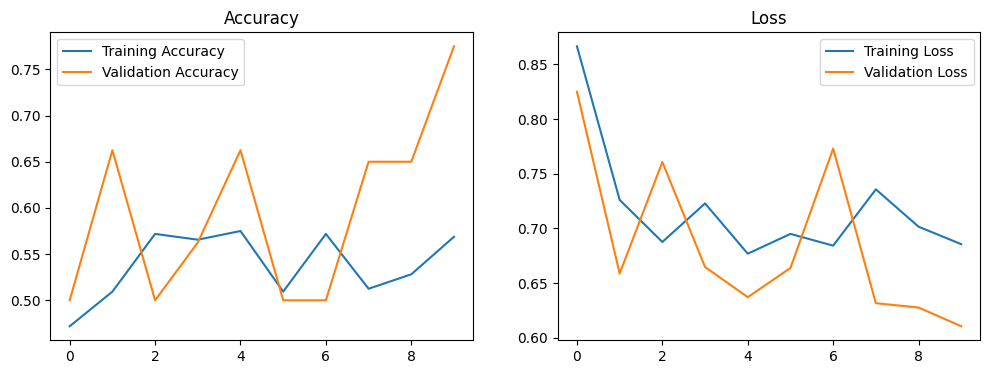

In [ ]:



data_dir = '/content/drive/My Drive/Dataset/Dataset'


dataset = image_dataset_from_directory(
    data_dir,
    image_size=(224, 224),
    label_mode='categorical'
)


images = []
labels = []

for image_batch, label_batch in dataset:
    images.append(image_batch.numpy())
    labels.append(label_batch.numpy())

images = np.concatenate(images, axis=0)
labels = np.concatenate(labels, axis=0)


train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=np.argmax(labels, axis=1)
)

train_augmenter = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_augmenter = ImageDataGenerator(rescale=1./255)  # No augmentation for test set, only normalization

# Apply augmentation to the training set and normalization to the test set
train_gen = train_augmenter.flow(
    train_images, train_labels, batch_size=32
)

test_gen = test_augmenter.flow(
    test_images, test_labels, batch_size=32, shuffle=False
)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_labels.shape[1], activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    steps_per_epoch=len(train_gen),
    validation_steps=len(test_gen)
)


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
import seaborn as sns


test_pred = model.predict(test_gen)
test_labels_classes = np.argmax(test_labels, axis=1)
predicted_classes = np.argmax(test_pred, axis=1)


3/3 [==============================] - 15s 4s/step


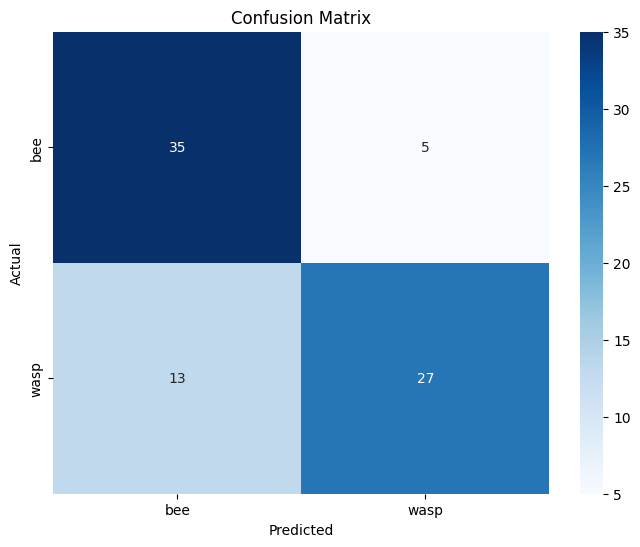

Classification Report:
              precision    recall  f1-score   support

         bee       0.73      0.88      0.80        40
        wasp       0.84      0.68      0.75        40

    accuracy                           0.78        80
   macro avg       0.79      0.78      0.77        80
weighted avg       0.79      0.78      0.77        80



In [ ]:
class_names = ['bee', 'wasp']
cm = confusion_matrix(test_labels_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(test_labels_classes, predicted_classes, target_names=class_names))